# TME4: Frequency filtering, color

In [164]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift
import matplotlib.pyplot as plt
from PIL import Image
import math

def imshow(I,title=None,size=500):
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()


## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of image `img/mandrill.png` (use functions seen in previous lessons). 

In [165]:
def computeFT(I):
    return np.fft.fft2(I)

def toVisualizeFT(If):
    return np.abs(np.fft.fftshift(If))

def toVisualizeLogFT(If):
    return np.log(1+np.abs(np.fft.fftshift(If)))

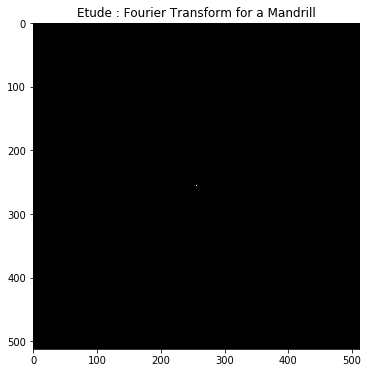

In [166]:
imageMandrill = np.array(Image.open('img/mandrill.png'))

spectrumMandrill = computeFT(imageMandrill)
spectrumVMandrill = toVisualizeFT(spectrumMandrill)
imshow(spectrumVMandrill,title="Etude : Fourier Transform for a Mandrill")

# show something more readable ?
# spectrumVMandrill = toVisualizeLogFT(spectrumMandrill)
# imshow(spectrumVMandrill,title="Logarithmic Fourier Transform for the Mandrill")

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at distance $f_c$ from the center (null frequency).

In [167]:
# step 1 : using Euclidean distances, this circular shape 
# will help isolate the lowest frequencies on a Fourier Transform.
def idealLowPassFilter(n,m,fc):
    fil = np.zeros((n,m)) # create a full mask.
    # centre_x, centre_y : find the centre - null frequency - of the picture.
    centre_x = n/2
    centre_y = m/2
    for x in range(n):
        for y in range(m):
            if np.floor(np.sqrt((x-centre_x)**2 + (y-centre_y)**2)) < fc:
                fil[x,y]=1 # unmask all the points that are close enough to the centre
    return fil

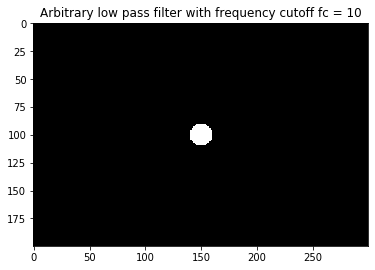

In [168]:
fil = idealLowPassFilter(200,300,10)
imshow(fil,"Arbitrary low pass filter with frequency cutoff fc = 10")

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (function `ifft2()` from module `numpy.fft`
 - return the real part of filtered image

In [169]:
# step 2 : apply the filtering operation on an actual image.
def lowPass(I,fc):
    fourier = computeFT(I)
    fourier = np.fft.fftshift(fourier) # shift the FT adequately
    filteredFourier = fourier*idealLowPassFilter(fourier.shape[0],fourier.shape[1],fc) # filter it
    filteredFourier = np.fft.ifftshift(filteredFourier) # reverse the shifting
    filteredImage = np.fft.ifft2(filteredFourier) # re-build image
    return np.abs(filteredImage)

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


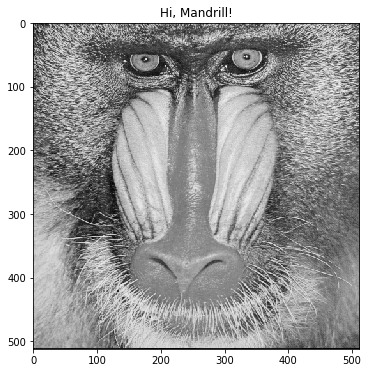

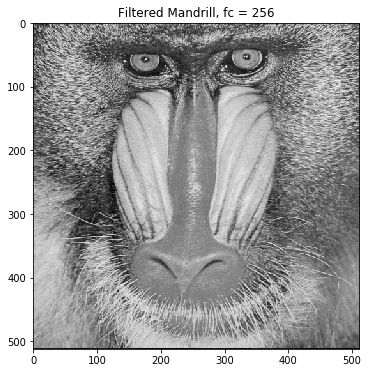

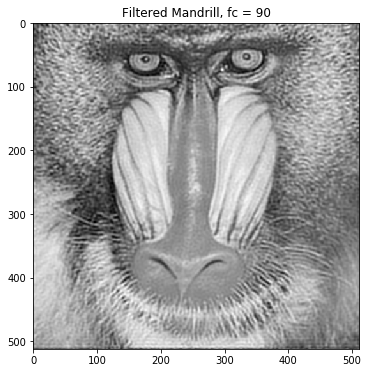

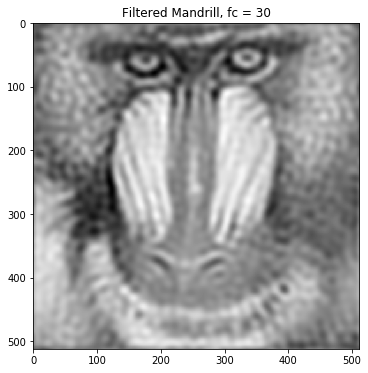

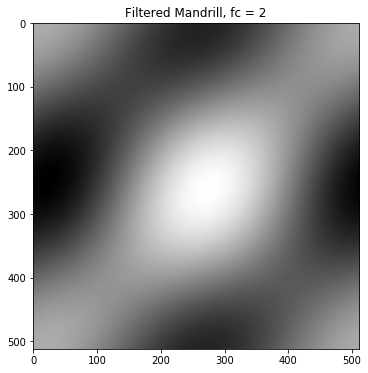

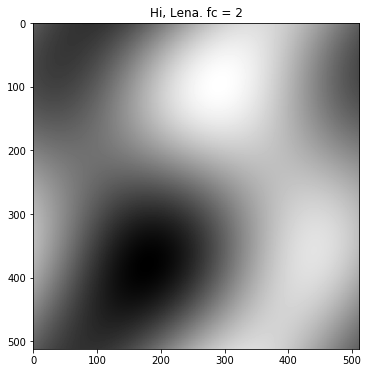

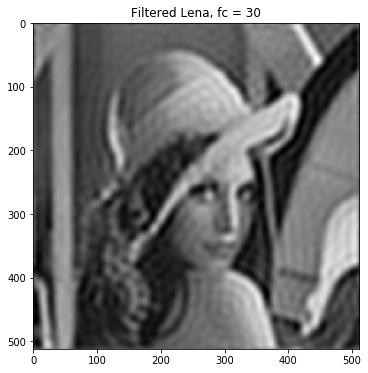

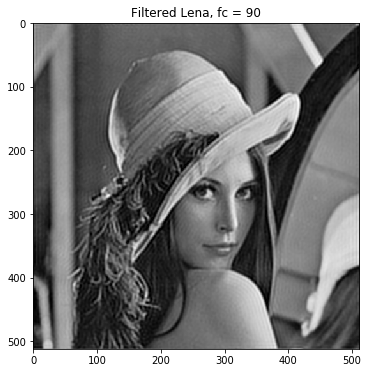

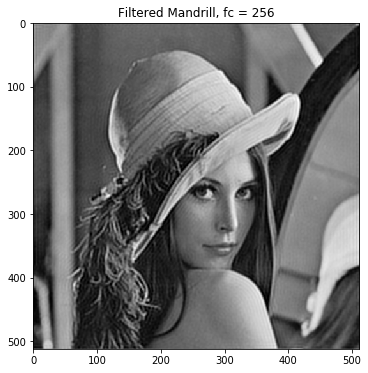

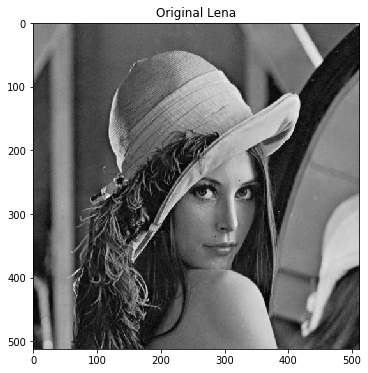

In [171]:
# trials on the mandrill
imshow(imageMandrill,"Hi, Mandrill!")
imshow(lowPass(imageMandrill,256),"Filtered Mandrill, fc = 256")
# there is naturally no difference between the 256-filtered image and the original file
imshow(lowPass(imageMandrill,90),"Filtered Mandrill, fc = 90")
imshow(lowPass(imageMandrill,30),"Filtered Mandrill, fc = 30")
imshow(lowPass(imageMandrill,2),"Filtered Mandrill, fc = 2")

# trials on Lena
imageLena = np.array(Image.open('img/lena.jpg'))
imshow(lowPass(imageLena,2),"Hi, Lena. fc = 2")
# if you look at both Lena and the last mandrill, can you tell which is which !?
imshow(lowPass(imageLena,30),"Filtered Lena, fc = 30")
imshow(lowPass(imageLena,90),"Filtered Lena, fc = 90")
imshow(lowPass(imageLena,256),"Filtered Lena, fc = 256")
imshow(imageLena,"Original Lena")

A low-pass filter is usually used to smooth all surfaces in an image. This is the first obvious effect that appears as fc decreases. The frontiers between the represented objects (the tiniest ones first) are blurred and broadened, as we cut off the high frequencies, that are responsible for creating textures.

The second effect is heavier. Excessive filtering leads to "cognitive" data loss. If you only keep the fundamental frequencie(s) of an image, you will get something like a 2D cosine function, that does not represent anything in particular. These structures are similar for almost all images : all recognisable features and frontiers will disappear and leave you with a nice, unuseful black and white blurry blob.

... but filters are renowned tools with proven benefits.
Indeed, if you temper the filtering, you might be able to use it to reduce the amount of tiny details in an image and focus on general shapes. This would help in pattern/face recognition. Use a moderate fc to reach that goal (around 30). For instance, using this for the mandrill picture could allow an AI to discard the light reflecting on its fur and consider its traits only from a global perspective. It could then, for instance, isolate the eye region from the nose region.

Of course, low-pass filters also have aesthetic uses. Applied with relatively high cutoff frequencies (around 100), they will discretely smooth any kind of surface - including skin - which is of high utility when taking a portrait.

-- note to self - Gaussian filters might do better.

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

To be able to treat the leftmost, rightmost, etc. rows and columns of an image, we will have to add some pixels on all four sides. These outskirts have to be of size d/2. (Indeed, the filter is a square structure of size d. It will be centered on pixel (x,y) at each step of the calculation, and on limit cases, e.g. on the rightmost column, half of it would exceed the image's borders.)

d being odd, we have to add a rounding method.
We will hence add **floor(d/2)** lines and rows on each direction.

We will use zero-padding (that is, we will fill said lines with zeros) instead of mirroring, etc. to simplify the handling of this first basic case.

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1.

In [173]:
def imagePad(I,h):
    padded = I.copy()
    padded = np.pad(padded,int(h.shape[0]/2),'constant') # easy
    return padded

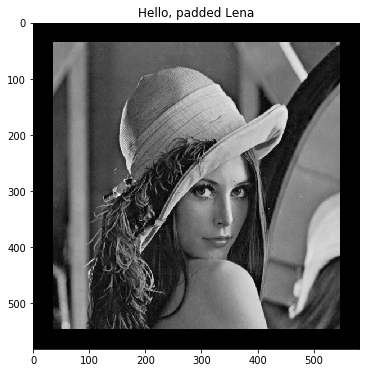

In [174]:
kernel = np.ones((70,70))
imshow(imagePad(imageLena,kernel),"Hello, padded Lena.")

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [175]:
def conv2(I,h):
    convolution = np.zeros(I.shape) # build a new matrix
    paddedI = imagePad(I,h) 
    for i in range(I.shape[0]): # go through original image WITHOUT the paddings
        for j in range(I.shape[1]):
            # the filtering operation will cover *this* area at each iteration:
            # one central pixel (x,y) and its neighbours in all directions
            square = paddedI[i:i+h.shape[0],j:j+h.shape[0]] 
            # this square must always be of size h.shape.
            # and we need to consider the padded image in case the neighbours don't exist.
            
            flipped = np.flip(h,axis=0) # kernel must flip - head over heels - before convolution
            
            # the convolved value for pixel(x,y)
            # is the sum of the kernel*pixelsvalue point-by-point multiplications
            # all over the isolated square of (x,y)'s neighbours
            convolution[i,j] = (square*flipped).sum() 
    return convolution

In [176]:
# To make sure that this function is mathematically valid, we conducted the following tests on paper:

# Kernel of size 3
kernel3 = np.ones((3,3))
kernel3 *= 1/(3*3)

# show values for a small part of the image
# >>> upper left-hand corner
print("Original Mandrill.\n",imageMandrill[0:9,0:9])

# Values expected : 
# conv2_pixel[0,0] (0+0+0+0+145+55+116+101)/9 = 46.3
# conv2_pixel[0,1] (0+0+0+145+55+48+116+101+39)/9 = 56.0
# ...
# conv2_pixel[7,7] (53+61+64+48+58+99+59+34+65)/9 = 60.1
# ...

# try the function out, and focus on the numerical values
print("\nFiltered Mandrill.\n", conv2(imageMandrill,kernel3)[0:9,0:9])
# well, it works !

# In this case, using imageMandrill was an educated choice. 
# Indeed, its upper left-hand corner has quite diverse pixel values.
# On imageLena, it basically is a chunk of grey,
# and verfying a mean computation on highly similar values is of null interest.

Original mandrill
 [[145  55  48  88 137  90  61  33  70]
 [116 101  39  67  90  54  65  45  92]
 [ 76 114  46  46  97  59  59  47 108]
 [ 70 135  95  48  82 120  53  46  71]
 [ 86 121 131  49  76  87  74  50  55]
 [ 81  75 158  60  72  95  43  46  73]
 [ 43  51 133 129  70 122  53  61  64]
 [ 33  51 111 153  86 119  48  58  99]
 [ 57  48  55 116 146 128  59  34  65]]

Filtered mandrill
 [[ 46.33333333  56.          44.22222222  52.11111111  58.44444444
   55.22222222  38.66666667  40.66666667  41.77777778]
 [ 67.44444444  82.22222222  67.11111111  73.11111111  80.88888889
   79.11111111  57.          64.44444444  70.77777778]
 [ 68.          88.          76.77777778  67.77777778  73.66666667
   75.44444444  60.88888889  65.11111111  74.        ]
 [ 66.88888889  97.11111111  87.22222222  74.44444444  73.77777778
   78.55555556  66.11111111  62.55555556  76.77777778]
 [ 63.11111111 105.77777778  96.88888889  85.66666667  76.55555556
   78.          68.22222222  56.77777778  71.77777778]

4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

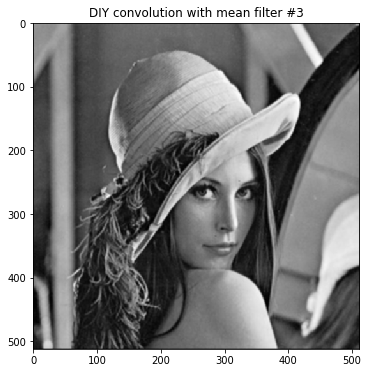

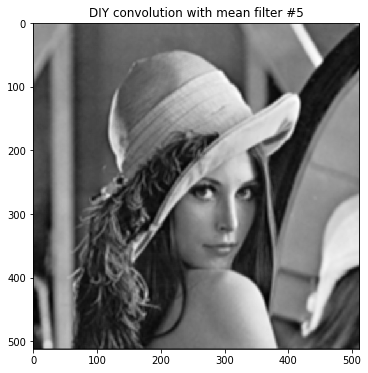

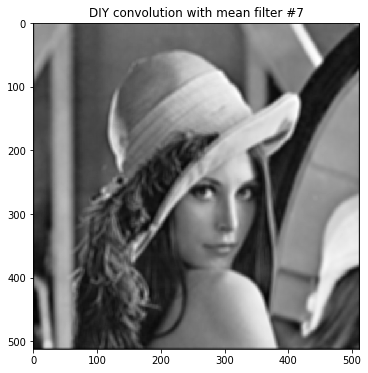

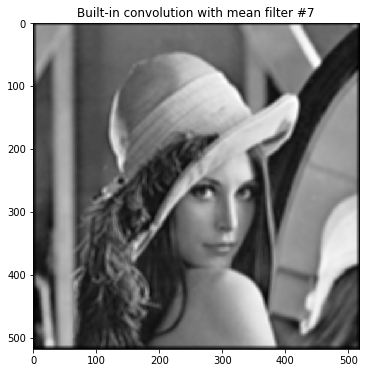

In [177]:
from scipy.signal import convolve2d

# Kernel of size 3 was already defined above
convolved3 = conv2(imageLena,kernel3)
imshow(convolved3,"DIY convolution with mean filter #3")

# Kernel of size 5
kernel5 = np.ones((5,5))
kernel5 *= 1/(5*5)
convolved5 = conv2(imageLena,kernel5)
imshow(convolved5,"DIY convolution with mean filter #5")

# Kernel of size 7
kernel7 = np.ones((7,7))
kernel7 *= 1/(7*7)
convolved7 = conv2(imageLena,kernel7)
imshow(convolved7,"DIY convolution with mean filter #7")

# Adequacy test with same kernel
convolvedBuiltin = convolve2d(imageLena,kernel7)
imshow(convolvedBuiltin, "Built-in convolution with mean filter #7")

Lena's traits are attenuated. This effect evolves quite fast as the size of the kernel grows.

What we also notice is the black border that appears around the image.
This is due to zero-padding : our convolution function considers that pixels of weight 0 loom all around the image and participate in the computation. Their presence will have an obvious effect on the mean values near the borders (especially when those are initially rather light) and make them smaller - i.e. darker - than expected.

5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

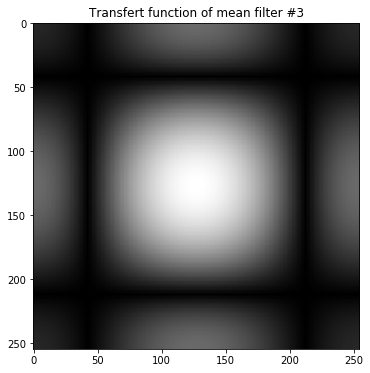

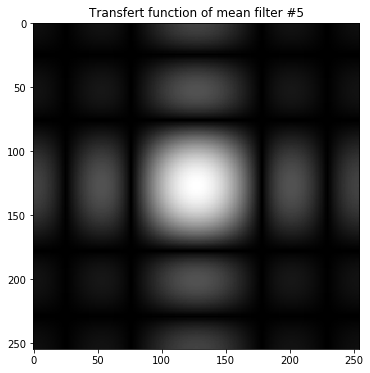

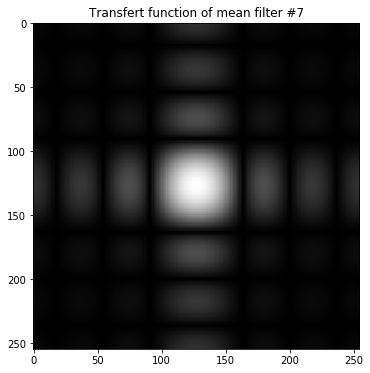

In [178]:
# Padding and visualisations
kernel3 = np.pad(kernel3,int((256-3)/2),'constant')
ftk3 = computeFT(kernel3)
ftk3 = toVisualizeLogFT(ftk3)
imshow(ftk3, "Transfert function of mean filter #3")
kernel5 = np.pad(kernel5,int((256-5)/2),'constant')
ftk5 = computeFT(kernel5)
ftk5 = toVisualizeLogFT(ftk5)
imshow(ftk5, "Transfert function of mean filter #5")
kernel7 = np.pad(kernel7,int((256-7)/2),'constant')
ftk7 = computeFT(kernel7)
ftk7 = toVisualizeLogFT(ftk7)
imshow(ftk7, "Transfert function of mean filter #7")

6. Interpretation: what the analytic expression of the transfert function of a mean filter. Is  it an ideal low pass filter?

The transfert function of a mean filter is a bidimensional sinc function (a cartesian product of two 1D sinc) with a central high peak and smaller satellite nodes. 
This cannot be an ideal low-pass filter since a sinc is unbound - the filter has unbound frequential support. 

7. Bonus question: perform the same study for the Gaussian kernel. Determine sigma in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

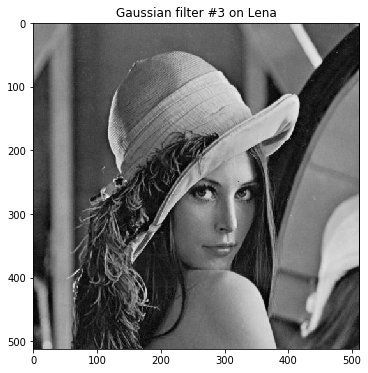

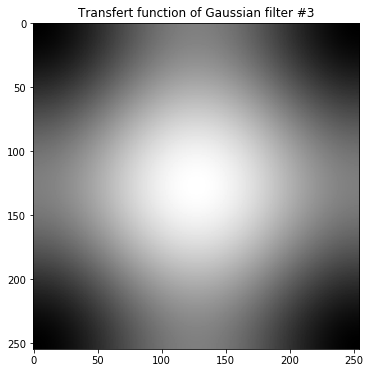

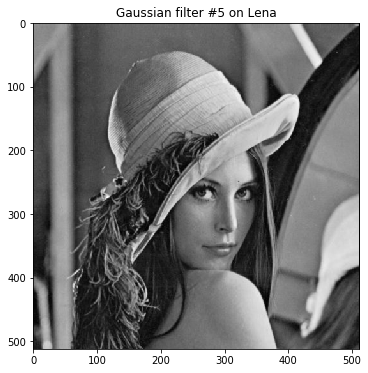

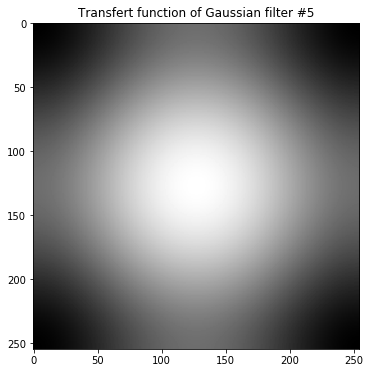

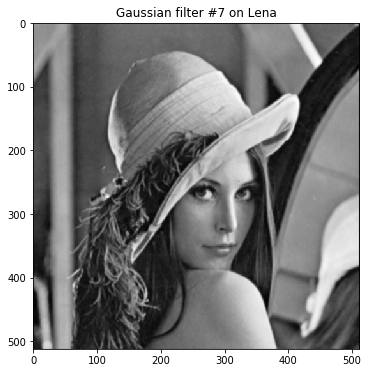

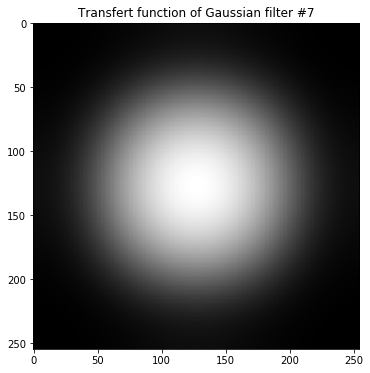

In [179]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n = 2*np.ceil(3*sigma) + 1
    x,y = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
    return  np.exp( (-x**2-y**2)/(2*sigma*sigma))

# Gaussian kernel of size 3
gaussian3 = gaussianKernel(1/3)
convolvedG3 = conv2(imageLena,gaussian3)
imshow(convolvedG3, "Gaussian filter #3 on Lena")
# visualisation
gaussian3 = np.pad(gaussian3,int((256-gaussian3.shape[0])/2),'constant')
ftg3 = computeFT(gaussian3)
ftg3 = toVisualizeLogFT(ftg3)
imshow(ftg3, "Transfert function of Gaussian filter #3")

# Gaussian kernel of size 5
gaussian5 = gaussianKernel(0.5)
convolvedG5 = conv2(imageLena,gaussian5)
imshow(convolvedG5, "Gaussian filter #5 on Lena")
# visualisation
gaussian5 = np.pad(gaussian5,int((256-gaussian5.shape[0])/2),'constant')
ftg5 = computeFT(gaussian5)
ftg5 = toVisualizeLogFT(ftg5)
imshow(ftg5, "Transfert function of Gaussian filter #5")

# Gaussian kernel of size 7
gaussian7 = gaussianKernel(1)
convolvedG7 = conv2(imageLena,gaussian7)
imshow(convolvedG7, "Gaussian filter #7 on Lena")
# visualisation
gaussian7 = np.pad(gaussian7,int((256-gaussian7.shape[0])/2),'constant')
ftg7 = computeFT(gaussian7)
ftg7 = toVisualizeLogFT(ftg7)
imshow(ftg7, "Transfert function of Gaussian filter #7")

As compared to the mean filters, the smoothing effect is slower with a Gaussian kernel. 

The transfert function shows it : the effects of Gaussian filters on images are less intense, in the sense that the frequencies kept (the white part of the spectra shown) are spread more widely across the domain. They are not concentrated in that "cross" shape we have been observing for the mean filters.

The FT of a Gaussian is a Gaussian >>> still unbound frequential support, thus still not an ideal filter.

## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

In [128]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]
# copy-paste TME3.

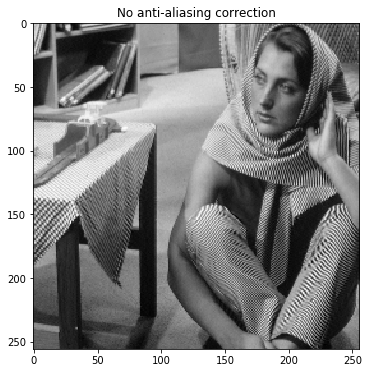

In [181]:
imageBarbara = np.array(Image.open('img/barbara.png'))
sampledBarbara = subSample2(imageBarbara)
imshow(sampledBarbara, "No anti-aliasing correction")

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

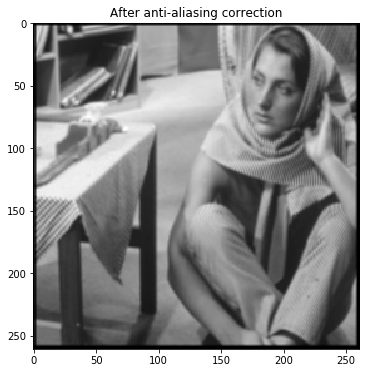

In [138]:
def antiAliasingFilter(n,m):
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A

noAlias = antiAliasingFilter(10,10) # generate filter
sampledBarbara = convolve2d(imageBarbara,noAlias) # convolve filter
sampledBarbara = subSample2(sampledBarbara) # re-sample
imshow(sampledBarbara, "After anti-aliasing correction")

The anti-aliasing filter discards high frequencies. 

3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

In both cases, the high frequencies are lost - the texture of the lady's trousers, the texture of the napkin.

On the first case, the culprit is aliasing. The highest frequencies could not be reconstructed and got translated into a very annoying "psychedelic" pattern that hinders the reading of the image.

On the second case, we voluntarily let go of said high frequencies (by applying a low-pass filter) to prevent that pattern from appearing. It is a compromise that makes the sampled image look more "natural", although it does not really match the original.

## Exercice 3: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

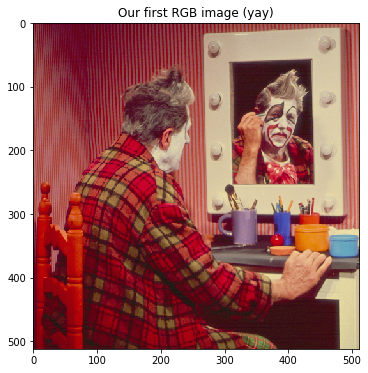

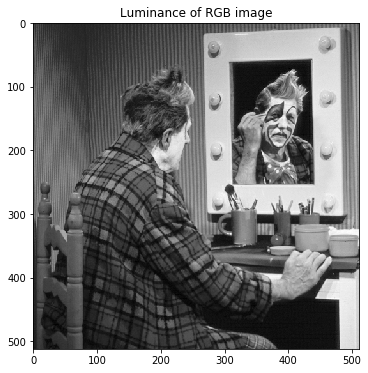

Shape of original image: (512, 512, 3)

Shape of flattened version: (512, 512)


In [143]:
imageClown = np.array(Image.open('img/clown.bmp'))
imageLuminances = np.array(Image.open('img/clown_lumi.bmp'))

imshow(imageClown, "Our first RGB image (yay)")
imshow(imageLuminances,"Luminance of RGB image")

print("Shape of original image:",imageClown.shape)
print("\nShape of flattened version:",imageLuminances.shape)

The clown.bmp image has three channels that represent its red, green and blue components. 
The other is a "flattened" version that shows the mean of these three values for each pixel. It is an 8-bit number that naturally translates to greyscale.

That's how you easily convert a colourful picture to nostalgic shades of grey.

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

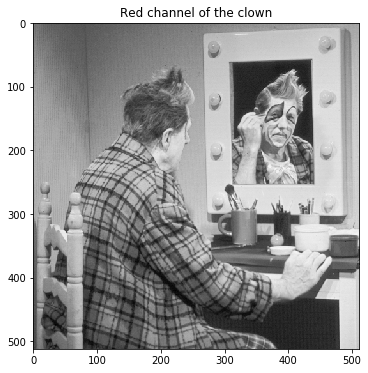

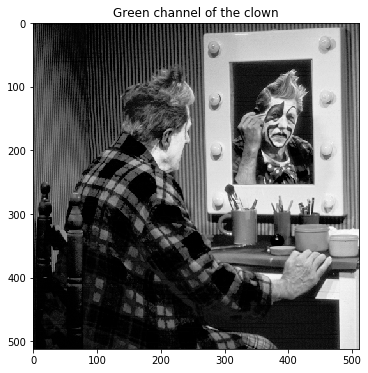

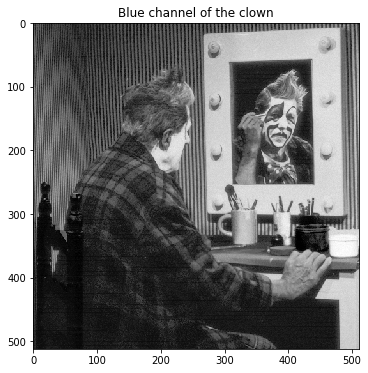

In [145]:
# isolate first (red) channel
clownRed = imageClown[:,:,0]
imshow(clownRed,"Red channel of the clown")

# isolate second (green) channel
clownGreen = imageClown[:,:,1]
imshow(clownGreen,"Green channel of the clown")

# isolate third (blue) channel
clownBlue = imageClown[:,:,2]
imshow(clownBlue,"Blue channel of the clown")

These three displays allow us to quantify the participation of each channel in the final result.
It looks like red is the dominant (empirically true) since its isolated channel is lighter than the others: it has, on average, rather high values for all its pixels. 

Pixels that are dark on the original image will look dark on the three channels. Pixels that are white on the original image will look white on the three channels. This is additive colour synthesis.

Again, the channels are shown as greyscale images - since their values are only coded on 8 bits, they are automatically recognised as such. 

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

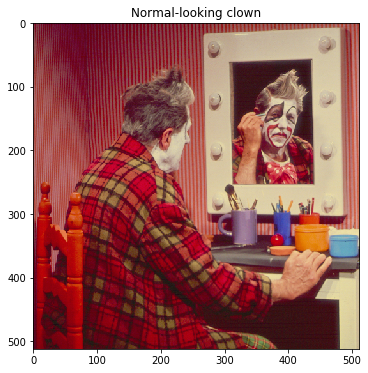

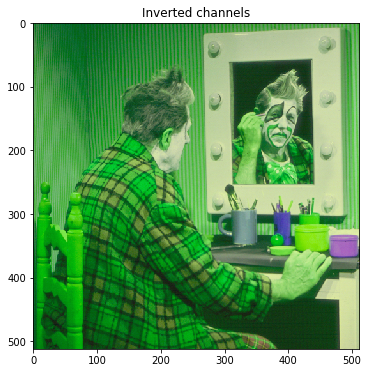

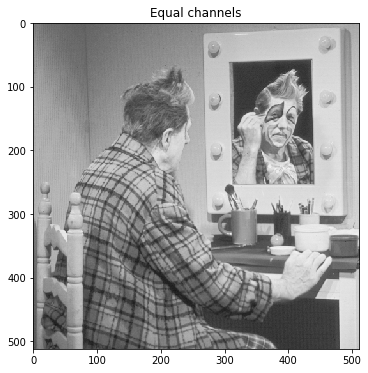

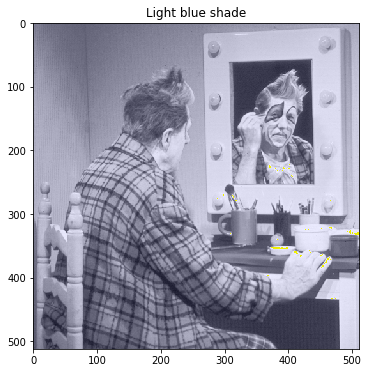

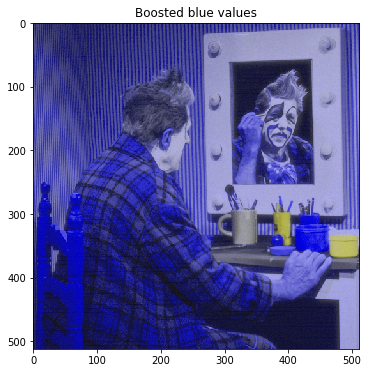

In [182]:
# natural combination
clownNatural = np.stack((clownRed,clownGreen,clownBlue),axis=2)
imshow(clownNatural,"Normal-looking clown")

# inverting red and green :
# Recall that red was the dominant. If I put the values of the red channel on position G,
# (and no part of the coding paradigm would impede that)
# then green will become the new dominant, as observed below.
clownInvertedChannels = np.stack((clownGreen,clownRed,clownBlue),axis=2)
imshow(clownInvertedChannels,"Inverted channels")

# when the three values are equal, no colour will take over, which means >>> greyscale
clownEqualAll = np.stack((clownRed,clownRed,clownRed),axis=2)
imshow(clownEqualAll,"Equal channels")

# having fun
clownTiltBlue = np.stack((clownRed,clownRed,clownRed+20,axis=2)
imshow(clownTiltBlue,"Light blue shade")

# boosting blue, boosting green, minimising red
clownFullBlue = np.stack((clownBlue,clownBlue,clownRed),axis=2)
imshow(clownFullBlue,"Boosted blue values")

4. Write a code that allows the see the first channel with red colors, the second channel in green, and the blue channel in blue.

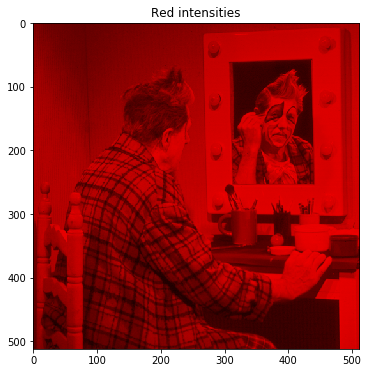

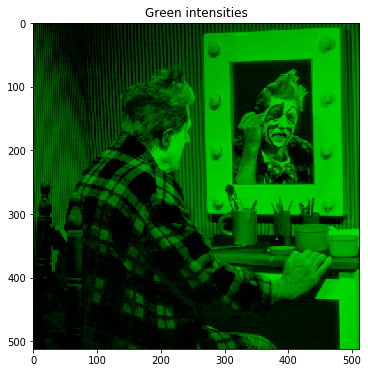

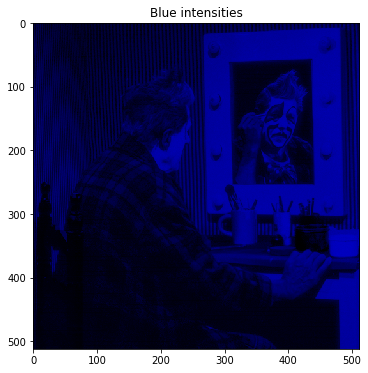

In [183]:
# Merrier displays
clownRealRed = np.stack((clownRed,np.zeros(clownRed.shape),np.zeros(clownRed.shape)),axis=2)
clownRealRed /= 255
imshow(clownRealRed,"Red intensities")

clownRealGreen = np.stack((np.zeros(clownGreen.shape),clownGreen,np.zeros(clownGreen.shape)),axis=2)
clownRealGreen /= 255
imshow(clownRealGreen,"Green intensities")

clownRealBlue = np.stack((np.zeros(clownBlue.shape),np.zeros(clownBlue.shape),clownBlue),axis=2)
clownRealBlue /= 255
imshow(clownRealBlue,"Blue intensities")